<a href="https://colab.research.google.com/github/LowForest/face_detector/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip uninstall -y thinc spacy ydf grpcio-status grpcio opencv-python-headless || true
!pip install -U pip
!pip install "numpy==1.26.4" "protobuf==4.25.3" "opencv-python==4.8.1.78" "mediapipe==0.10.21"

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [21]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
import numpy as np
import cv2, time, base64
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, HTML, Javascript, display, update_display
from IPython.display import Image as IPyImage
from google.colab.output import eval_js

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z)
      for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style()
    )

    # Handedness text
    h, w, _ = annotated_image.shape
    xs = [lm.x for lm in hand_landmarks]
    ys = [lm.y for lm in hand_landmarks]
    tx = int(min(xs) * w)
    ty = int(min(ys) * h) - MARGIN
    ty = max(ty, 20)  # tránh tràn trên
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (tx, ty), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)
  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [22]:
def overlay_hud(bgr_image, hands_count, fps):
  text = f"Hands: {hands_count} | FPS: {fps:.1f}"
  cv2.putText(bgr_image, text, (10, 24), cv2.FONT_HERSHEY_SIMPLEX,
              0.7, (0, 255, 0), 2, cv2.LINE_AA)
  return bgr_image

def data_url_to_bgr(data_url: str):
  """Convert JS canvas dataURL -> OpenCV BGR image."""
  if not data_url:
    return None
  header, encoded = data_url.split(',', 1)
  np_data = np.frombuffer(base64.b64decode(encoded), np.uint8)
  bgr = cv2.imdecode(np_data, cv2.IMREAD_COLOR)
  return bgr

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


In [23]:
from mediapipe.tasks import python as mp_python
from mediapipe.tasks.python import vision
import os

if not os.path.exists('hand_landmarker.task'):
    raise FileNotFoundError("Thiếu hand_landmarker.task — chạy lại Cell 1.")

base_options = mp_python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=2,
    running_mode=vision.RunningMode.VIDEO
)
detector = vision.HandLandmarker.create_from_options(options)
print("HandLandmarker ready (VIDEO mode).")

HandLandmarker ready (VIDEO mode).


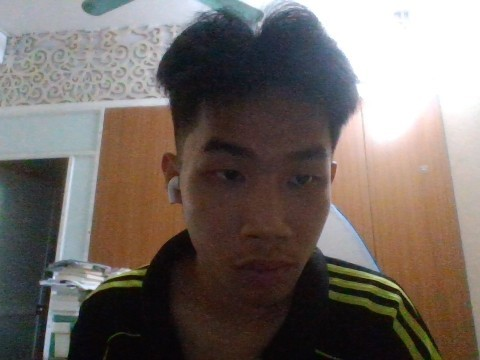

In [24]:
HTML_SNAP = r"""
<div id="snap-wrap" style="text-align:center;margin:8px 0;font-family:system-ui,sans-serif">
  <video id="snap-video" autoplay playsinline muted
         style="width:480px;height:360px;background:#000;border-radius:8px;object-fit:cover;display:block;margin:0 auto"></video>
  <div style="margin-top:8px">
    <button id="snap-start" style="padding:6px 12px">Start</button>
    <button id="snap-capture" style="padding:6px 12px">Capture</button>
    <button id="snap-stop" style="padding:6px 12px">Stop</button>
    <span id="snap-status" style="margin-left:10px;color:#0a8">idle</span>
  </div>
</div>
<script>
(() => {
  const v = document.getElementById('snap-video');
  const st = document.getElementById('snap-status');
  let stream = null;

  async function start() {
    try {
      if (stream) stop();
      stream = await navigator.mediaDevices.getUserMedia({video:{width:{ideal:480},height:{ideal:360}}, audio:false});
      v.srcObject = stream;
      await v.play();
      st.textContent = 'live'; st.style.color = '#0a8';
      return true;
    } catch(e){ console.error(e); st.textContent='permission error'; st.style.color='#c33'; return false; }
  }
  function stop() {
    if(stream){ stream.getTracks().forEach(t=>t.stop()); stream=null; }
    v.srcObject=null; st.textContent='stopped'; st.style.color='#888'; return true;
  }
  function capture(q=0.9){
    if(!stream) return null;
    const c=document.createElement('canvas'); c.width=480; c.height=360;
    const ctx=c.getContext('2d'); ctx.drawImage(v,0,0,c.width,c.height);
    return c.toDataURL('image/jpeg', q);
  }
  document.getElementById('snap-start').onclick = start;
  document.getElementById('snap-stop').onclick  = stop;
  document.getElementById('snap-capture').onclick = ()=>{};
  // expose locally for this cell
  window._snap = { start, stop, capture };
})();
</script>
"""
display(HTML(HTML_SNAP))

# tự thử start (nếu bị chặn, bấm Start rồi chạy lại 2 dòng dưới)
_ = eval_js("window._snap.start()")
data_url = eval_js("window._snap.capture(0.9)")
if data_url:
    from IPython.display import display
    import cv2
    bgr = data_url_to_bgr(data_url)
    ok, buf = cv2.imencode('.jpg', bgr, [cv2.IMWRITE_JPEG_QUALITY, 90])
    display(IPyImage(data=buf.tobytes()))
else:
    print("Chưa live. Bấm Start rồi chạy lại 2 dòng cuối trong cell để Capture.")

Realtime running... (nhấn Stop để dừng)


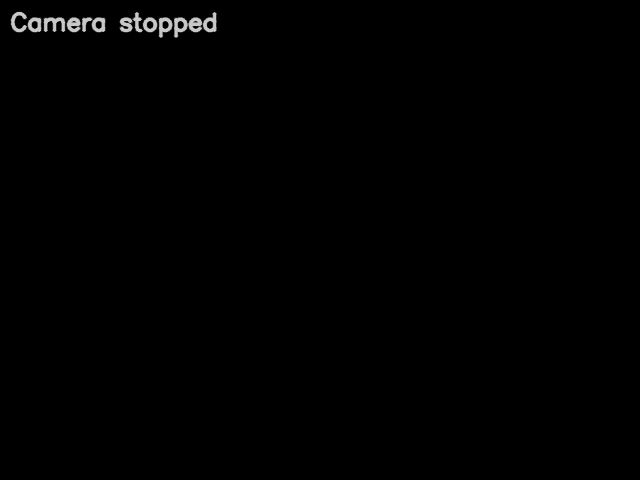

Webcam stopped.


In [32]:
WIDGET = r"""
<div id="rt-wrap" style="text-align:center; margin:8px 0; font-family:system-ui,sans-serif">
  <video id="rt-video" autoplay playsinline muted
         style="position:absolute; left:-9999px; width:1px; height:1px; opacity:0;"></video>
  <div style="margin-top:8px">
    <button id="rt-start" style="padding:6px 12px">Start</button>
    <button id="rt-stop"  style="padding:6px 12px">Stop</button>
    <span id="rt-status" style="margin-left:10px;color:#0a8">idle</span>
  </div>
</div>
<script>
(() => {
  const v  = document.getElementById('rt-video');
  const st = document.getElementById('rt-status');
  let stream = null;

  async function startWebcam(){
    try{
      if(stream) stopWebcam();
      stream = await navigator.mediaDevices.getUserMedia({
        video:{ width:{ideal:640}, height:{ideal:480} }, audio:false
      });
      v.srcObject = stream;
      await v.play();
      st.textContent='live'; st.style.color='#0a8';
      return true;
    }catch(e){
      console.error(e);
      st.textContent='permission error'; st.style.color='#c33';
      return false;
    }
  }
  function stopWebcam(){
    if(stream){ stream.getTracks().forEach(t=>t.stop()); stream=null; }
    v.srcObject=null; st.textContent='stopped'; st.style.color='#888';
    return true;
  }
  function isStreaming(){
    return !!(stream && stream.getVideoTracks().length &&
              stream.getVideoTracks()[0].readyState==='live');
  }
  function captureFrame(q=0.75){
    if(!isStreaming()) return null;
    const c=document.createElement('canvas'); c.width=640; c.height=480;
    const ctx=c.getContext('2d'); ctx.drawImage(v,0,0,c.width,c.height);
    return c.toDataURL('image/jpeg', q);
  }

  document.getElementById('rt-start').onclick = startWebcam;
  document.getElementById('rt-stop').onclick  = stopWebcam;
  window._rt = { startWebcam, stopWebcam, isStreaming, captureFrame };
})();
</script>
"""
display(HTML(WIDGET))

# 5B) Auto-start; nếu bị chặn quyền, bấm Start rồi chạy lại cell
_ = eval_js("window._rt.startWebcam()")

# Chờ webcam live
t0 = time.perf_counter()
while True:
    live = eval_js("window._rt.isStreaming && window._rt.isStreaming()")
    if live or (time.perf_counter() - t0 > 12):
        break
    time.sleep(0.2)
if not live:
    raise RuntimeError("Camera chưa live trong Cell 5. Bấm **Start** rồi chạy lại cell.")

# 5C) Tạo detector NGAY TRONG CELL 5 (tránh dính timestamp cũ)
base_opts = mp_python.BaseOptions(model_asset_path='hand_landmarker.task')
detector = vision.HandLandmarker.create_from_options(vision.HandLandmarkerOptions(
    base_options=base_opts,
    num_hands=2,
    running_mode=vision.RunningMode.VIDEO
))

# === helper: hiển thị khung đen khi dừng ===
def show_black_frame(display_handle, w=640, h=480, text=""):
    black = np.zeros((h, w, 3), dtype=np.uint8)
    if text:
        cv2.putText(black, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200,200,200), 2, cv2.LINE_AA)
    ok, buf = cv2.imencode('.jpg', black, [cv2.IMWRITE_JPEG_QUALITY, 80])
    img_obj = IPyImage(data=buf.tobytes())
    if display_handle is None:
        return display(img_obj, display_id=True)
    else:
        update_display(img_obj, display_id=display_handle.display_id)
        return display_handle

# 5D) Vòng lặp realtime (timestamp đơn điệu + đen màn khi Stop)
target_fps = 24
frame_dt = 1.0 / target_fps
alpha, fps = 0.9, 0.0
t_prev = time.perf_counter()
t_start = t_prev
display_handle = None
last_w, last_h = 640, 480

print("Realtime running... (nhấn Stop để dừng)")

try:
    while True:
        # Nếu người dùng ấn Stop: hiển thị khung đen rồi thoát
        if not eval_js("window._rt.isStreaming()"):
            display_handle = show_black_frame(display_handle, last_w, last_h, "Camera stopped")
            print("Webcam stopped.")
            break

        data_url = eval_js("window._rt.captureFrame(0.75)")
        if data_url is None:
            time.sleep(0.02)
            continue

        # Decode base64 -> BGR
        header, encoded = data_url.split(',', 1)
        b = np.frombuffer(base64.b64decode(encoded), np.uint8)
        bgr = cv2.imdecode(b, cv2.IMREAD_COLOR)
        if bgr is None:
            continue

        # Cập nhật kích thước mới nhất (để khi stop hiển thị đen đúng size)
        last_h, last_w = bgr.shape[:2]

        # -> RGB & MediaPipe Image
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

        # timestamp đơn điệu (ms)
        ts_ms = int((time.perf_counter() - t_start) * 1000)

        # Detect
        result = detector.detect_for_video(mp_image, ts_ms)

        # Vẽ overlay
        annotated = draw_landmarks_on_image(rgb, result)
        out_bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
        hands_count = len(result.hand_landmarks)

        # FPS EMA
        t_now = time.perf_counter()
        inst_fps = 1.0 / max(t_now - t_prev, 1e-6)
        fps = alpha * fps + (1 - alpha) * inst_fps
        t_prev = t_now

        # HUD
        cv2.putText(out_bgr, f"Hands: {hands_count} | FPS: {fps:.1f}",
                    (10, 24), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

        ok, buf = cv2.imencode('.jpg', out_bgr, [cv2.IMWRITE_JPEG_QUALITY, 80])
        if not ok:
            continue
        img_obj = IPyImage(data=buf.tobytes())
        if display_handle is None:
            display_handle = display(img_obj, display_id=True)
        else:
            update_display(img_obj, display_id=display_handle.display_id)

        # pace theo target_fps
        time.sleep(max(0.0, frame_dt - (time.perf_counter() - t_now)))

except KeyboardInterrupt:
    # Người dùng dừng thủ công: cũng hiển thị khung đen
    display_handle = show_black_frame(display_handle, last_w, last_h, "Interrupted")
    print("Interrupted.")
finally:
    try:
        detector.close()
    except Exception:
        pass
    try:
        _ = eval_js("window._rt.stopWebcam()")
    except Exception:
        pass